<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/TD_and_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Modules

In [ ]:
import numpy as np
from operator import add, sub
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm

%matplotlib inline
np.set_printoptions(linewidth=np.inf)

# Design the Grid World

![gridworld](https://drive.google.com/uc?id=1qlvYlafej-hkB8iOwy3oaaqF0r3s2SIh)

The agent starts in the cell marked $S$.

When it reaches the cell marked $G$, it will receive a reward of $100$ and the episode ends.

When it reaches a cell marked $W$, it will receive a reward of $-25$ and the episode ends.

Every other step will be rewarded with $-1$. 

The agent has eight (non-deterministic) actions:

* It can move to an adjacent cell according to eight-neighborhood.
* With probability 0.8, the desired action is carried out. With probability 0.1, the agent deviates from the desired direction by one cell to the left or to the right (axis-parallel moves become diagonal moves and vice versa).
* Actions that would move the agent off the grid are handled by truncating the resulting cell coordinates to valid grid coordinates. Hence, almost all diagonal moves outside the grid (except for moves into cells extending corners) will result in a horizontal or vertical move.

The agent's initial policy is defined as:

* Move to the right with probability 0.5
* Move to the upper right with probability 0.25
* Move to the lower right with probability 0.25

In [ ]:
gridSize = (5,7)

startCell = (2,0)
goalCell = (2,6)
obstacles = (
    (0,3), (0,4), (0,5), (0,6),
    (1,6),
    (2,2), (2,4),
    (3,1), (3,2), (3,5),
    (4,3), (4,4), (4,5)
)

goalReward = 100
wallReward = -25

rewards = np.zeros(gridSize)-1
for cell in obstacles:
    rewards[cell] = wallReward
rewards[goalCell] = goalReward


# possible actions: NW, N, NE, E, SE, S, SW, W
actions = ((-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1))
nActions = len(actions)


initPolicy = lambda: np.random.choice(range(nActions), p = [0, 0, 0.25, 0.5, 0.25, 0, 0, 0])


def step(state, actionID, deterministic=True):
    action = actions[actionID]
    # desired action is performed with probability 0.8
    # else action deviates to the left or right
    if not deterministic:
        rand = np.random.random()
        if rand > 0.8:
            # action deviates left
            if rand > 0.9:
                thetaDev = -np.pi/4
            # action deviates right
            else:
                thetaDev = np.pi/4
            rotMat = np.array([[np.cos(thetaDev),-np.sin(thetaDev)],
                            [np.sin(thetaDev),np.cos(thetaDev)]])
            # deviated action
            action = np.round(rotMat @ action).astype(int)
    # determine the new state
    state = tuple(map(add,state,action))
    # truncate state to valid cell coordinates if agent moves off grid
    state = tuple(np.clip(state,0,(gridSize[0]-1,gridSize[1]-1)))
    # end episode if terminal state (goal or wall)
    done = rewards[state] in (goalReward, wallReward)
    return (state, rewards[state], done)


# TD(0) Policy Evaluation
def policyEvaluation(policy, V=np.zeros(gridSize), gamma=0.9, alpha=0.2, decay=True,
                     episodes=10000, deterministic=True, stats=False):
    if stats:
        nVisit = np.zeros(gridSize, dtype=int)
        nEpisode = np.zeros(episodes, dtype=int)
        returnPerEpisode = np.zeros(episodes)
    if decay and not stats:
        nVisit = np.zeros(gridSize, dtype=int)
    # repeat for each episode
    for episode in range(episodes):
        # starting from an initial state
        state = startCell
        # repeat for each step of the episode
        while True:
            # get an action for the current state
            actionID = policy()
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID)
            if decay:
                alpha = 1/(nVisit[state]+1)
            # update state value
            V[state] += alpha*(reward + gamma*V[state_] - V[state])
            # move on to the next state
            state = state_
            if stats:
                nVisit[state] += 1
                nEpisode[episode] += 1
                returnPerEpisode[episode] += reward
            if decay and not stats:
                nVisit[state] += 1
            # until terminal state reached
            if done:
                break
    return V if not stats else V, (nVisit, np.average(nEpisode), np.average(returnPerEpisode))


# cheat by initializing Q from V following the initial policy
# (simulating a model of the environment) to converge faster
# (refer to assignment 3 lookahead function)
def initQ(V, gamma=0.9):
    Q=np.zeros((*gridSize,nActions))
    for s in np.ndindex(gridSize):
        if rewards[s] not in (goalReward, wallReward):
            for i, a in enumerate(actions):
                for thetaDev, trans_prob in ((0,0.8), (-np.pi/4,0.1), (np.pi/4,0.1)):
                    rotMat = np.array([[np.cos(thetaDev),-np.sin(thetaDev)],
                                       [np.sin(thetaDev),np.cos(thetaDev)]])
                    a = np.round(rotMat @ a).astype(int)
                    s_ = tuple(map(add,s,a))
                    s_ = tuple(np.clip(s_,0,(gridSize[0]-1,gridSize[1]-1)))
                    Q[s][i] += trans_prob*(rewards[s_] + gamma*V[s_])
    return Q


def epsGreedy(Qstate, epsilon=0.1):
    return np.random.choice(range(nActions)) if(np.random.random()<epsilon) else np.argmax(Qstate)

def softMax(Qstate, tau=42):
    actionProb = np.exp(Qstate/tau)
    actionProb /= np.sum(actionProb)
    return np.random.choice(range(nActions), p=actionProb)

   
# Q-Learning: Off-Policy TD Control
def policyImprovement(Q=np.zeros((*gridSize,nActions)), epsilon=0.1, tau=42, gamma=0.9, alpha=0.2,
                      decay=True, episodes=10000, softmax=False, deterministic=True, stats=False):
    if stats:
        nVisit = np.zeros(gridSize, dtype=int)
        nEpisode = np.zeros(episodes, dtype=int)
        returnPerEpisode = np.zeros(episodes)
    if decay:
        nQVisit = np.zeros((*gridSize,nActions), dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # repeat for each step of the episode
        while True:
            # get an action form the current state using a policy derived from Q
            actionID = softMax(Q[state],tau) if softmax else epsGreedy(Q[state],epsilon)
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID, deterministic)
            if decay:
                nQVisit[state][actionID] += 1
                alpha = 1/nQVisit[state][actionID]
            # update action value
            Q[state][actionID] += alpha*(reward + gamma*np.max(Q[state_]) - Q[state][actionID])
            # move on to the next state
            state = state_
            if stats:
                nVisit[state] += 1
                nEpisode[episode] += 1
                returnPerEpisode[episode] += reward
            # until terminal state reached
            if done:
                break
    return Q if not stats else Q, (nVisit, np.average(nEpisode), np.average(returnPerEpisode))


def plotPolicy(policy, deterministic=True):
    plt.rc('figure', figsize=gridSize)
    ax = plt.gca()
    ax.axis([0,gridSize[1],0,gridSize[0]])
    ax.grid(True, color='k', linewidth=1.5)
    ax.set_aspect(1)
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.add_patch(Rectangle((startCell[1],startCell[0]),1,1,color='dodgerblue'))
    ax.add_patch(Rectangle((goalCell[1],goalCell[0]),1,1,color='springgreen'))
    for cell in obstacles:
        ax.add_patch(Rectangle((cell[1],cell[0]),1,1,color='orangered'))
    state = startCell
    while True:
        actionID = np.argmax(policy[state])
        nextState, _, done = step(state, actionID, deterministic)
        if not deterministic:
            action = tuple(map(sub,nextState,state))
            actionID = actions.index(action)
        if actionID==0:
            ax.arrow(state[1]+0.75,state[0]+0.75, -0.5,-0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==1:
            ax.arrow(state[1]+0.5,state[0]+0.8, 0,-0.6, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==2:
            ax.arrow(state[1]+0.25,state[0]+0.75, 0.5,-0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==3:
            ax.arrow(state[1]+0.2,state[0]+0.5, 0.6,0, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==4:
            ax.arrow(state[1]+0.25,state[0]+0.25, 0.5,0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==5:
            ax.arrow(state[1]+0.5,state[0]+0.2, 0,0.6, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==6:
            ax.arrow(state[1]+0.75,state[0]+0.25, -0.5,0.5, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        elif actionID==7:
            ax.arrow(state[1]+0.8,state[0]+0.5, -0.6,0, head_width=0.25, head_length=0.15,
                     linewidth=2, length_includes_head=True, fill=True)
        state = nextState
        if done:
            break
    plt.show()


def displayStats(stats):
    nVisit, avgEpisodeLength, avgReturnPerEpisode = stats
    nVisit = nVisit.copy()
    print('Average Return per Episode: ', avgReturnPerEpisode)
    print('Average Episode Length: ', avgEpisodeLength)
    print()
    fig, axs = plt.subplots(2,1,figsize=(12,12))
    for ax in axs:
        ax.axis([0,gridSize[1],0,gridSize[0]])
        ax.grid(True, color='k', linewidth=2)
        ax.set_aspect(1)
        ax.invert_yaxis()
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none')
        ax.set_xticklabels([])
        ax.xaxis.set_ticks_position('none')
    axs[0].set_title('Number of times each cell was visited', fontsize=18)
    for s in np.ndindex(gridSize):
        if s==startCell:
            axs[0].add_patch(Rectangle((s[1],s[0]),1,1,color='dodgerblue'))
        elif s==goalCell:
            axs[0].add_patch(Rectangle((s[1],s[0]),1,1,color='springgreen'))
        elif s in obstacles:
            axs[0].add_patch(Rectangle((s[1],s[0]),1,1,color='orangered'))
        axs[0].text(s[1]+0.5, s[0]+0.5, str(nVisit[s]), ha='center', va='center', fontsize=16)
    nVisit[tuple(zip(*obstacles))] = 0
    hot_r = cm.get_cmap('hot_r')
    cmap = ListedColormap(hot_r(np.linspace(0, 0.75, 256)))
    axs[1].set_title('Heat Map (walls masked)', fontsize=18)
    im = axs[1].imshow(nVisit, cmap=cmap, extent=(0,gridSize[1],gridSize[0],0))
    for cell in obstacles:
        axs[1].add_patch(Rectangle((cell[1],cell[0]),1,1,color='dimgray'))
    plt.show()

# Task 5.1

Randomly generate 10000 episodes according to the initial policy.

Compute the state value V(s) for each visited state using TD(0) Policy Evaluation.

State Values for initial policy:

[[  0.     0.   -21.77   0.     0.     0.     0.  ]
 [  0.   -19.09 -15.33  -9.98   7.35  10.18   0.  ]
 [-21.39 -22.65   0.   -12.93   0.    50.87   0.  ]
 [  0.     0.     0.     0.    -6.35   0.    52.27]
 [  0.     0.     0.     0.     0.     0.    18.63]] 

Average Return per Episode:  -22.7846
Average Episode Length:  2.4846



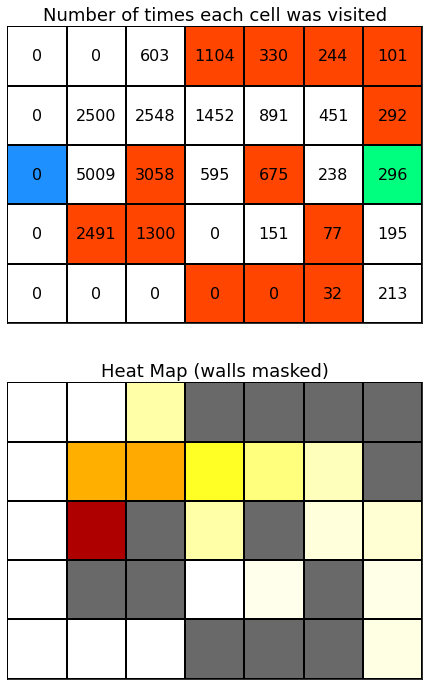

In [ ]:
V, stats = policyEvaluation(initPolicy, deterministic=False, stats=True)
print('State Values for initial policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

# Task 5.2

Starting from the initial policy, choose actions using ε-greedy action selection (ε=0.1)

Improve the policy by Q-learning for 10,000 episodes.

Compute the resulting state value V(s) for each grid cell.

Visualize the resulting policy using arrows.

## Epsilon Greedy Policy, Non-Deterministic Actions

100%|██████████| 10000/10000 [00:04<00:00, 2407.95it/s]


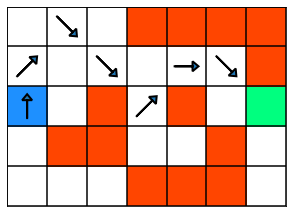


State Values for learned policy:

[[14.34 21.98 19.97  0.    0.    0.    0.  ]
 [14.65 19.05 30.05 38.85 63.3  83.75  0.  ]
 [ 9.11 11.42  0.   44.06  0.   86.2   0.  ]
 [ 1.97  0.    0.   23.34 54.12  0.   98.38]
 [-4.16 -4.26 -4.36  0.    0.    0.   59.64]] 

Average Return per Episode:  27.0667
Average Episode Length:  7.5333



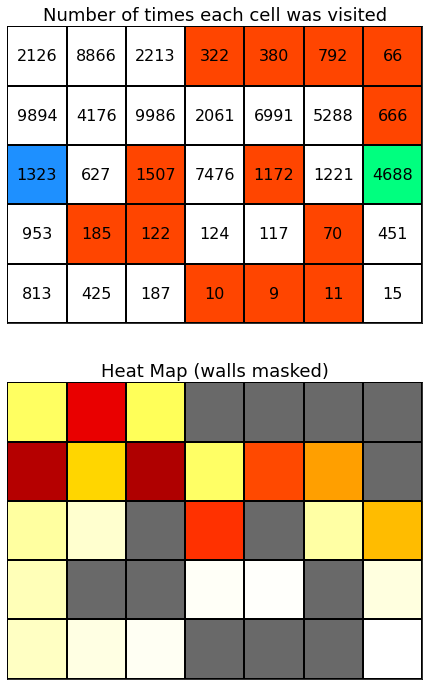

In [ ]:
Q, stats = policyImprovement(deterministic=False, stats=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## Epsilon Greedy Policy, Deterministic Actions

100%|██████████| 10000/10000 [00:02<00:00, 3601.26it/s]


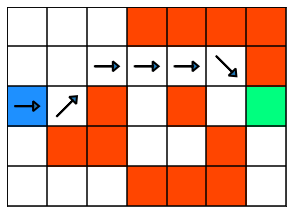


State Values for learned policy:

[[ 54.95  62.17  70.19   0.     0.     0.     0.  ]
 [ 54.95  62.17  70.19  79.1   89.   100.     0.  ]
 [ 54.95  62.17   0.    79.1    0.   100.     0.  ]
 [ 54.95   0.     0.    79.1   89.     0.   100.  ]
 [ 54.95  62.17  70.19   0.     0.     0.    89.  ]] 

Average Return per Episode:  66.7895
Average Episode Length:  5.9605



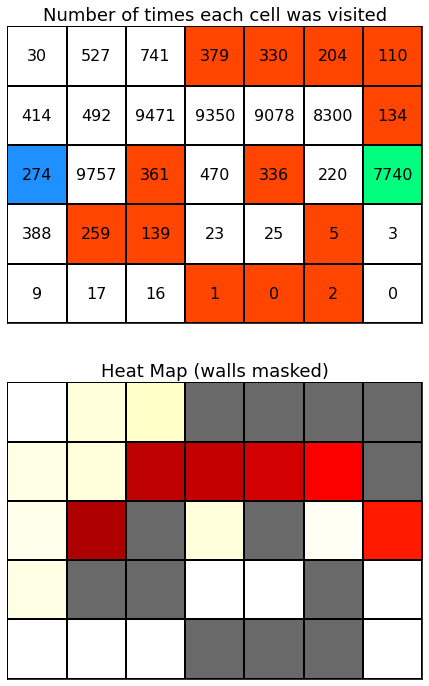

In [ ]:
Q, stats = policyImprovement(deterministic=True, stats=True)
print()
plotPolicy(Q, deterministic=True)
print()
V = np.max(Q, axis=2)
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## Softmax Action Selection, Non-Deterministic Actions

100%|██████████| 10000/10000 [00:23<00:00, 420.09it/s]


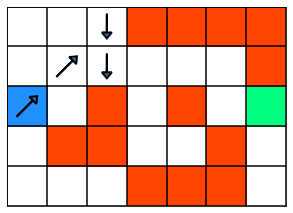


State Values for learned policy:

[[35.45 37.19 38.05  0.    0.    0.    0.  ]
 [35.16 36.54 39.75 43.48 63.33 87.29  0.  ]
 [34.67 35.2   0.   50.8   0.   85.22  0.  ]
 [32.93  0.    0.   34.53 56.24  0.   99.74]
 [31.01 29.52 28.43  0.    0.    0.   88.16]] 

Average Return per Episode:  -34.3607
Average Episode Length:  14.1232



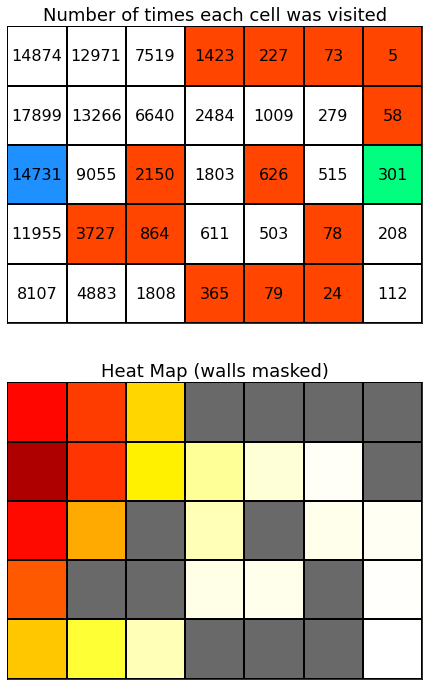

In [ ]:
Q, stats = policyImprovement(softmax=True, deterministic=False, stats=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## Softmax Action Selection, Deterministic Actions

100%|██████████| 10000/10000 [00:31<00:00, 317.80it/s]


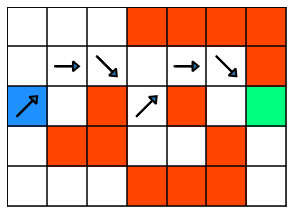


State Values for learned policy:

[[ 54.95  62.17  70.19   0.     0.     0.     0.  ]
 [ 54.95  62.17  70.19  79.1   89.   100.     0.  ]
 [ 54.95  62.17   0.    79.1    0.   100.     0.  ]
 [ 54.95   0.     0.    79.1   89.     0.   100.  ]
 [ 54.95  62.17  70.19   0.     0.     0.    89.  ]] 

Average Return per Episode:  -19.3524
Average Episode Length:  21.2524



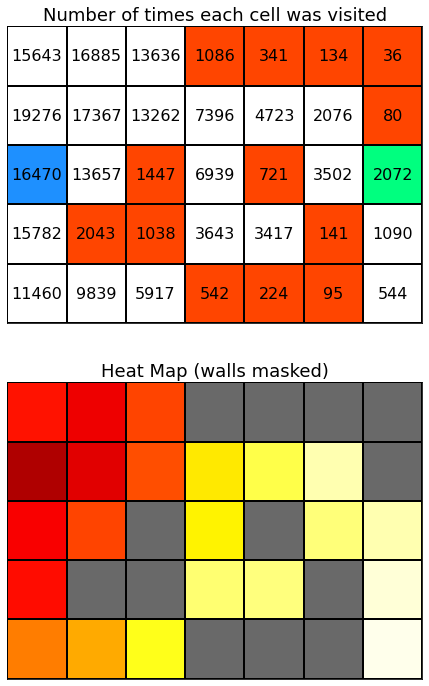

In [ ]:
Q, stats = policyImprovement(softmax=True, deterministic=True, stats=True)
print()
plotPolicy(Q, deterministic=True)
print()
V = np.max(Q, axis=2)
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)